# Imputation data post-processing and PCA analysis
Process VCF files from Michigan imputation server by removing imputed sites and fix variant IDs. We also perform MDS analysis to obtain covariates for association analysis.

In [5]:
[global]
original_genotypes = '~/Documents/GTEx/genotype_by_chrom/*.vcf.gz'
imputed_genotypes= '~/Documents/GTEx/gtex7/michigan_imputed/*.vcf.gz'
parameter: cwd = '~/Documents/GTEx'
phenotype = '~/Documents/GTEx/gtex7/sample_annotations/GTEx_Analysis_2016-01-15_v7_SubjectPhenotypesDS.txt'

[vcftools: provides = executable('vcftools')]
output: os.path.join(cwd, "bin/vcftools")
task: workdir = cwd
download:
  https://github.com/vcftools/vcftools/archive/master.zip
run:
  unzip master.zip
  cd vcftools-master
  bash autogen.sh
  ./configure; make
  mv src/cpp/vcftools ../bin
  cd ../
  rm -rf master.zip vcftools-master

## Genotype filtering and formatting
The primary goal here is to convert genotypes from VCF format to PLINK binary format, to make it easy to obtain various statistics and perform routine analysis down the road. During the conversion, imputed sites are removed and variant ID for tri-allelic sites are fixed. Also both the original and imputed data are converted and saved separately.

### VCF to PLINK conversion
Code chunk below converts from VCF to PLINK format, fixing variant ID issues along the course.

In [ ]:
%sosrun -J 8

[umich_to_plink_1, broad_to_plink_1]
# VCF to plink format
input: group_by = 'single'
output: "${_input!nn}.a2flipped.bed"
task: workdir = cwd
run:
  plink --vcf ${_input} --out ${_output!n} --make-bed

[umich_to_plink_2]
# Fix multi-allelic sites
# By changing duplicate SNP ID
input: group_by = 'single'
output: "${_input!n}.bim"
task: workdir = cwd
python:
    from collections import Counter
    import numpy as np

    dat = np.genfromtxt(${_output!r}, dtype = '<U48')
    counter = Counter()
    dup_list = dat[:,1]
    deduped = []
    for name in dup_list:
        new = name + '_' + str(counter[name]) if counter[name] else name
        counter.update({name: 1})
        deduped.append(new)
    dat[:,1] = np.array(deduped)
    np.savetxt(${_output!r}, dat, delimiter = '\t', fmt = '%s')

[umich_to_plink_3]
# Allele fix
input: group_by = 'single'
output: "${_input!nn}.bed"
task: workdir = cwd
run:
  paste <(cut -f2 ${_input!n}.bim) <(zcat ${_input!nn}.vcf.gz | grep -v "^#" | cut -f4) > ${_input!nn}.a2
  plink --bfile ${_input!n} \
        --a2-allele ${_input!nn}.a2 2 1 '#' \
        --out ${_output!n} --make-bed
  rm -f ${_input!nn}.a2

[broad_to_plink_2]
# Remove indel sites
input: group_by = 'single'
output: "${_input!n}.snp_only.bed"
task: workdir = cwd
run:
  awk '{if ((length($5) > 1 ) || (length($6) > 1)) {print $2}}' ${_input!n}.bim > ${_input!n}.exclude_id
  plink --bfile ${_input!n} --out ${_output!n} --make-bed \
        --exclude ${_input!n}.exclude_id \
  rm -f ${_input!n}.exclude_id

[umich_to_plink_4, broad_to_plink_3]
# Merge all files
parameter: project_name = "GTEx7"
output: "${cwd!a}/genotype_plink/${project_name}.bed"
task: workdir = cwd
run:
  echo ${input!n} | sed 's/ /\n/g' | grep -v chrX > plink.merge-list
  plink --bfile ${input[0]!n} --merge-list plink.merge-list --out ${output!n} \
        --chr 1-22 --make-bed
  rm plink.merge-list

[default_1]
input: original_genotypes
sos_run('broad_to_plink', project_name = "GTEx7.dbGaP")

[default_2]
input: imputed_genotypes
sos_run('imputed_genotypes', project_name = "GTEx7.Imputed")

### Remove imputed variant sites
Code chunk below compares `GTEx7.dbGap` and `GTEx7.Imputed` and extract only genotyped variants from imputation results. Additional filters on minor allele frequency and minor allele counts are also applied. The result is genotype input for eQTL discovery, saved in PLINK format.

In [8]:
%sosrun variants_filter
[variants_filter_1]
# Exclude imputed variants
include = "${cwd}/genotype_plink/GTEx7.dbGaP.bed"
input: "${cwd}/genotype_plink/GTEx7.Imputed.bed"
output: "${input!n}.genotyped.bed"
task: workdir = cwd
python:
    import pandas as pd
    imputed = pd.read_csv("${input!n}.bim", dtype = str, usecols = (0,1,3), header = None, sep = '\t')
    genotyped = pd.read_csv("${include!n}.bim", dtype = str, usecols = (0,1,3), header = None, sep = '\t')
    imputed[0] = imputed[0] + '_' + imputed[3]
    imputed.drop([3], axis = 1, inplace = True)
    genotyped[0] = genotyped[0] + '_' + genotyped[3]
    genotyped.drop([1,3], axis = 1, inplace = True)
    res = pd.merge(imputed, genotyped, how='inner', on=[0,0])
    res[1].to_csv("${input!n}.extract_id", header = False, index = False)

run:
    plink --bfile ${input!n} --out ${output!n} --extract ${input!n}.extract_id --make-bed
    rm -f ${input!n}.extract_id

[variants_filter_2]
# Filter by MAF, HWE etc
parameter: maf = 0.01
parameter: mac = 10
output: "${input!n}.filtered.bed"
task: workdir = cwd
run:
  plink --bfile ${input!n} --maf ${maf} --mac ${mac} --make-bed --out ${output!n}


~/Documents/GTEx/genotype_plink/GTEx7.dbGaP.bed


## Global ancestry PCA / MDS analysis

After LD pruning I perform MDS analysis via the `king` program. We want to find out in terms of PCA plot:

* If imputated data and original data behave the same
* Are there any difference before / after removing imputed sites

See code chunk below for implementation.

In [ ]:
[LD_pruning_1]
# Mark independent variants
parameter: pairwise_ld_param = '50 5 0.2'
parameter: maf = 0.1
depends: executable('plink')
input: pattern = '{name}.{ext}'
output: expand_pattern('{name}.prune.in')
task: workdir = cwd 
run:
  plink --bfile ${input!n} \
        --allow-no-sex \
        --maf ${maf} \
        --indep-pairwise ${pairwise_ld_param} \
        --out ${output!nn}
        
[LD_pruning_2]
# Select independent common variants
depends: executable('plink')
input: pattern = '{name}.prune.in'
output: "${cwd!a}/genotype_pca/${input!bn}.bed"
task: workdir = cwd 
run:
  plink --bfile ${input!nn} \
        --extract ${input} \
        --no-sex --no-pheno --no-parents \
        --make-bed \
        --out ${output!n}

[global_ancestry_1]
# global ancestry analysis via KING
# And fix family ID (replace by ancestry coding)
depends: executable('king'), phenotype
input: pattern = "{name}.{ext}"
output: expand_pattern('{name}.pc.ped')
task: workdir = cwd
run:
  # king -b ${input!n}.bed --pca 20 --prefix ${input!n}.
  # Would be much faster if I use MDS
  # One should use PCA to be more comparable to GTEx official results, though
  king -b ${input!n}.bed --mds --prefix ${input!n}.

python:
    import pandas as pd
    reference = pd.read_csv(${phenotype!ar}, dtype = str, usecols = (0,4), sep = '\t')
    reference['RACE'] = 'POP' + reference['RACE'].astype(str)
    fam = pd.read_csv(${output!r}, header = None, sep = ' ',
                      names = ['fid', 'sid', 'pid', 'mid', 'sex', 'phen'] + ['PC{}'.format(x+1) for x in range(20)])
    dat = pd.merge(reference, fam, left_on = 'SUBJID', right_on = "sid")
    dat.drop(['SUBJID', 'fid'], axis=1, inplace = True)
    dat.to_csv(${output!r}, sep = ' ', header = False, index = False)

[global_ancestry_2]
# scatter plot for global ancestry analysis result
# R plotly implementation
depends: R_library("plotly")
input: pattern = "{name}.ped" 
output: expand_pattern('{name}.html')
task: workdir = cwd 
R: 
   library(plotly)
   dat <- read.table(${input!r}, sep = ' ')
   for (i in 1:(ncol(dat) - 6 - 1)) {
       title <- paste(${input!bnr}, "PC", i, "vs", "PC", i + 1, sep = "_")
       p <- plot_ly(dat, x = dat[, 6 + i], y = dat[, 7 + i], text = dat[,2], color = dat[,1],
                    mode = "markers", type = 'scatter', visible = 'legendonly') %>% layout(title = title)
       htmlwidgets::saveWidget(as.widget(p), paste0(title, ".html"))
   }
run:
   foo () {
     echo '<html><body>'
     sed 's/^.*/<a href="&">&<\/a><br\/>/'
     echo '</body></html>'
   }
   mkdir -p ${input!n}; mv ${input!bn}*.html ${input!n}
   ls ${input!n}/*.html | foo > ${output}

[genotype_pca_broad]
input: "${cwd}/genotype_plink/GTEx7.dbGaP.bed"
sos_run("LD_pruning + global_ancestry")

[genotype_pca_umich]
input: "${cwd}/genotype_plink/GTEx7.Imputed.bed"
sos_run("LD_pruning + global_ancestry")

[genotype_pca_umich_filtered]
# Filtered imputation data removing imputed sites
input: "${cwd}/genotype_plink/GTEx7.Imputed.genotyped.filtered.bed"
sos_run("LD_pruning + global_ancestry")

In [ ]:
%sosrun genotype_pca_broad
%sosrun genotype_pca_umich
%sosrun genotype_pca_umich_filtered

### Plot Broad PCA results

GTEx has provided in dbGaP the PCA analysis done at Broad before imputation. I want to verify it agrees with my PCA analysis for imputed data. Code chunk below matches sample label with Broad PCA results to prepare data for plot, and saved to a temporary file `/tmp/GTExPCA.ped` (previewed below) to be used by the same plot routine I developed here.

In [2]:
%preview dat --limit 20
import pandas as pd
reference = pd.read_csv('/home/gaow/Documents/GTEx/gtex7/sample_annotations/GTEx_Analysis_2016-01-15_v7_SubjectPhenotypesDS.txt', dtype = str, usecols = (0,4), sep = '\t')
reference['RACE'] = 'POP' + reference['RACE'].astype(str)
ped = pd.read_csv('/home/gaow/Documents/GTEx/gtex7/sample_annotations/GTEx_Analysis_2016-01-15_v7_WholeGenomeSeq_635Ind_PostVarQC_20genotPCs.txt', header = 0, sep = '\t')
ped['FID'] = ['-'.join(x.split('-')[:2]) for x in ped['FID']]
dat = pd.merge(reference, ped, left_on = 'SUBJID', right_on = "FID")
dat.drop(['SUBJID', 'FID'], axis=1, inplace = True)
dat.insert(2, 'pid', 0)
dat.insert(3, 'mid', 0)
dat.insert(4, 'sex', 0)
dat.insert(5, 'phen', 0)
dat.to_csv('/tmp/GTExPCA.ped', sep = ' ', header = False, index = False)

>>> dat:

,RACE,IID,pid,mid,sex,phen,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
0,POP2,GTEX-1117F-0003-SM-6WBT7,0,0,0,0,-0.1037,-0.0173,0.0017,-0.0040,-0.0058,0.0242,0.0494,0.0363,0.0148,0.0078,-0.0163,-0.0062,0.0277,0.0480,-0.0201,0.0200,0.0160,0.0284,0.0127,-0.0108
1,POP3,GTEX-111CU-0003-SM-6WBUD,0,0,0,0,0.0118,-0.0030,0.0008,0.0035,-0.0056,0.0280,0.0083,0.0286,0.0243,-0.0548,-0.0168,-0.0437,0.1153,0.0304,-0.0249,0.0151,-0.0416,0.0030,-0.0181,0.0334
2,POP3,GTEX-111FC-0001-SM-6WBTJ,0,0,0,0,0.0112,-0.0080,0.0308,-0.0060,-0.0510,-0.0628,0.0228,0.0150,-0.0085,-0.0017,0.0253,-0.0817,0.0068,-0.0402,0.0240,-0.0239,-0.0145,-0.0038,-0.0631,0.0508
3,POP3,GTEX-111VG-0004-SM-6WBTS,0,0,0,0,0.0162,-0.0081,0.0227,0.0012,0.0113,-0.1192,-0.0349,0.0186,0.0217,-0.0433,-0.0147,-0.0225,0.0155,-0.0297,-0.0011,0.0007,-0.0403,0.0125,-0.0368,-0.0635
4,POP3,GTEX-111YS-0004-SM-6WBTN,0,0,0,0,0.0175,-0.0096,0.0167,0.0004,0.0009,0.0355,-0.0374,0.0124,-0.0167,-0.0148,0.0821,-0.0129,-0.0342,-0.0373,-0.0556,-0.0108,0.0323,0.1122,0.0727,0.0458
5,POP3,GTEX-1122O-0004-SM-6WBTE,0,0,0,0,0.0164,-0.0106,0.0126,0.0095,-0.0071,0.0092,-0.0248,-0.0161,-0.0067,0.0761,0.0254,0.0063,-0.0007,0.0669,0.0470,0.0562,-0.0444,0.0246,-0.0122,-0.0003
6,POP3,GTEX-1128S-0001-SM-6WBUH,0,0,0,0,0.0162,-0.0111,0.0381,0.0040,-0.0686,-0.0057,0.0981,-0.0097,0.0041,-0.0037,0.0169,-0.0118,0.0815,0.0103,0.0162,-0.0010,0.0206,0.1035,-0.0151,-0.0730
7,POP3,GTEX-113JC-0001-SM-6WBTD,0,0,0,0,0.0116,0.0034,-0.0083,0.0309,0.0034,-0.0109,0.0003,-0.0243,-0.0307,0.0142,0.0326,0.0423,0.0068,0.0129,-0.0216,0.0266,-0.0193,0.0070,0.0093,-0.0136
8,POP3,GTEX-117XS-0001-SM-6WBTA,0,0,0,0,0.0156,-0.0071,-0.0125,-0.0109,-0.0061,-0.0012,0.0424,-0.0062,0.0274,-0.0261,-0.0177,-0.0058,-0.0064,-0.0355,-0.0460,-0.0137,-0.0478,-0.0027,-0.0340,-0.0099
9,POP3,GTEX-117YW-0003-SM-6WBSY,0,0,0,0,0.0123,-0.0054,-0.0933,-0.0185,-0.0038,0.0138,-0.0049,-0.0120,0.0028,0.0225,0.0909,-0.0295,-0.0074,-0.0055,-0.0348,0.0092,-0.0302,0.0288,0.0345,-0.0330


In [ ]:
%sosrun pca_plot_broad
[pca_plot_broad]
input: '/tmp/GTExPCA.ped'
sos_run("global_ancestry:2")

## PCA results
Broad provided:

> img/gtex_broad_pca.png (32.6 KiB):

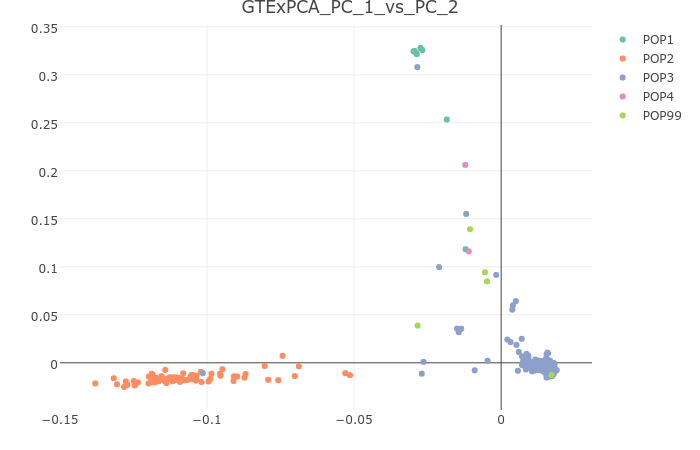

In [3]:
%preview img/gtex_broad_pca.png

Broad, my analysis:

> img/gtex_dbgap_pca_gaow.png (33.7 KiB):

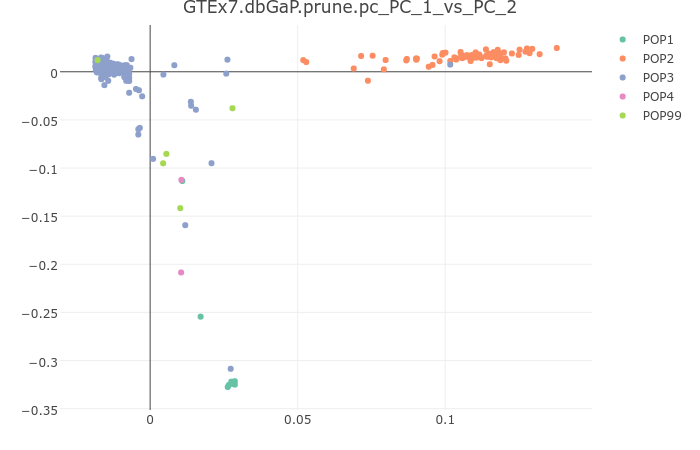

In [4]:
%preview img/gtex_dbgap_pca_gaow.png

Imputed, my analysis:

> img/gtex_umich_imputed_pca.png (35.0 KiB):

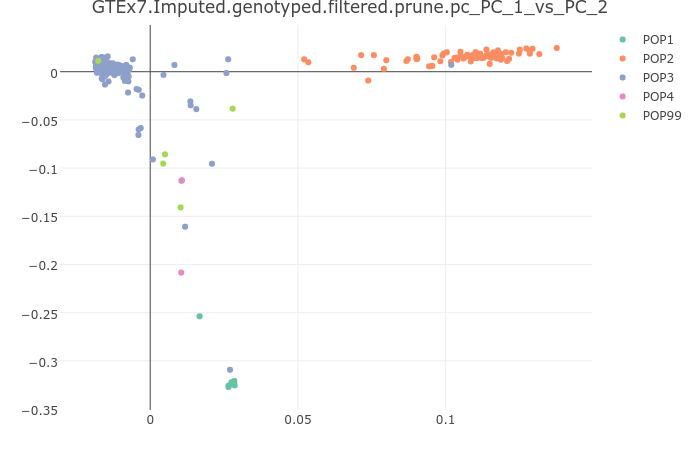

In [5]:
%preview img/gtex_umich_imputed_pca.png

The results are quite consistent across different datasets.

In [3]:
%sessioninfo

SoS Version,0.9.7.4
Kernel,python3
Language,Python3
Version,"3.6.0 |Continuum Analytics, Inc.| (default, Dec 23 2016, 12:22:00) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
pandas,0.19.2
